In [50]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import torch

import utils

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [85]:
yaml_path='./data/images_1/2x2_final2/to_andrew/concept_learning_goodrun/seed=4.yaml'
ckpt_paths=[
    './data/images_1/2x2_final2/to_andrew/concept_learning_goodrun/ckpts/ckpt_step=4140.pth',
    './data/images_1/2x2_final2/to_andrew/concept_learning_goodrun/ckpts/ckpt_step=5865.pth',
    './data/images_1/2x2_final2/to_andrew/concept_learning_goodrun/ckpts/ckpt_step=6343.pth',
    './data/images_1/2x2_final2/to_andrew/concept_learning_goodrun/ckpts/ckpt_step=7355.pth',]
steps=[4140,5865, 6343, 7355]

In [86]:
#load data settings from config
config=utils.load_config(yaml_path)
color_means=np.array(config["data_params"]["color"]["means"])
size_means=np.array(config["data_params"]["size"]["means"])

In [87]:
imss=[]
for ckpt_path in ckpt_paths:
    model=utils.get_model(config)
    model.load_state_dict(torch.load(ckpt_path))
    model=model.to(device)
    model=model.eval()

    cs=[]
    for i in range(4):
        l=[[0,0],[0,1],[1,0],[1,1]][i]#first axis is color second is size
        c=torch.tensor([0.,0., 0., 0., *color_means[l[1]], size_means[l[0]], 0.,0.,0.])
        cs.append(c)
    cs=torch.stack(cs).to(dtype=torch.float32,device=device)

    rep=4
    with torch.no_grad():
        ims=model.generate(cs.repeat(rep,1)).detach().cpu().numpy()
        ims=np.clip(ims.transpose(0,2,3,1),0,1).reshape(4,rep,32,32,3).transpose(1,0,2,3,4)
    imss.append(ims)
imss=np.stack(imss,axis=0)
imss.shape

(4, 4, 4, 32, 32, 3)

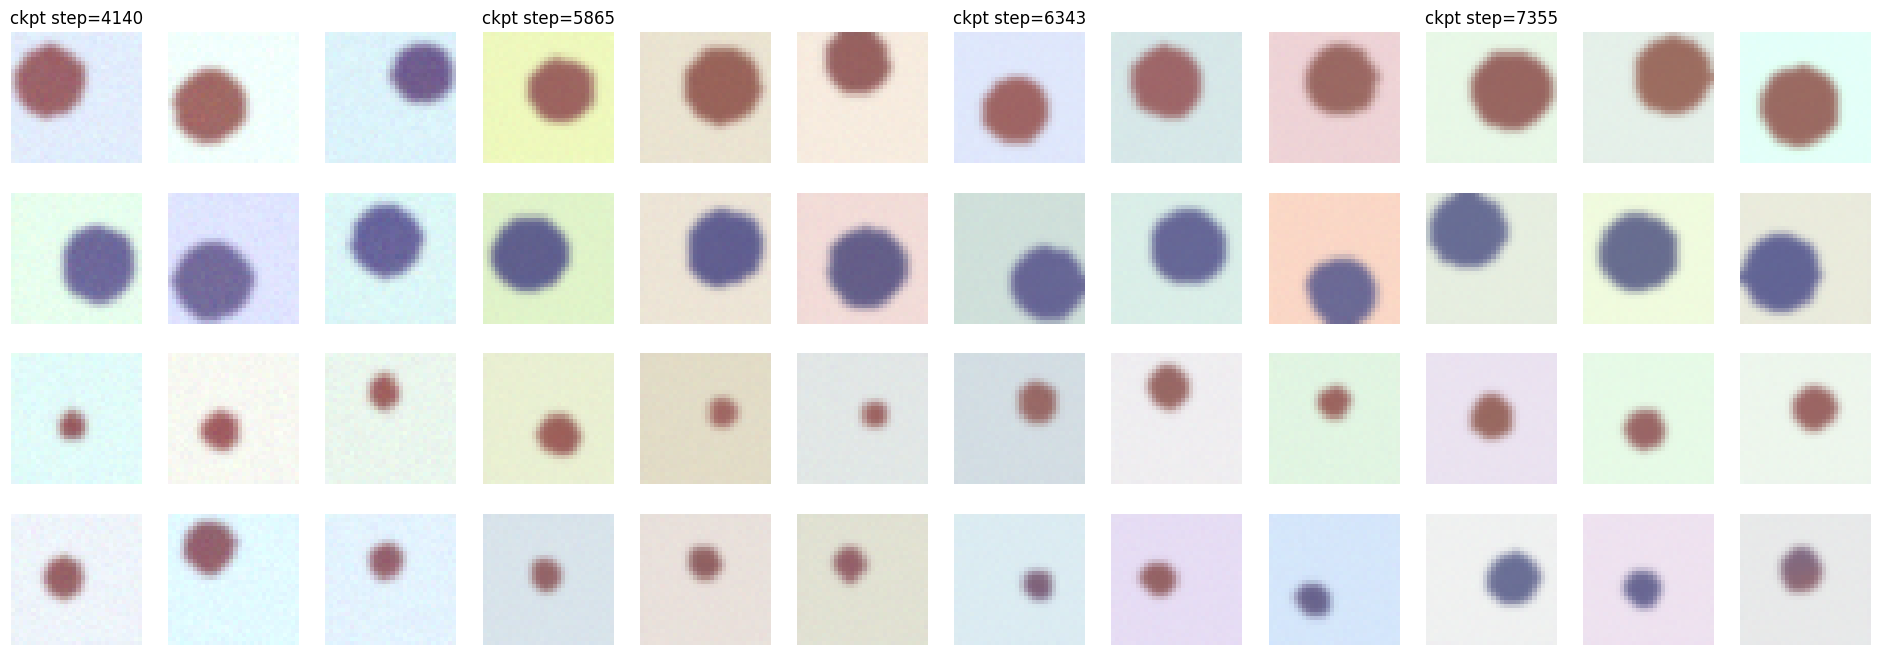

In [88]:
plt.figure(figsize=(24,8))
showrep=3
n_blocks=len(imss)
n_rows=4
for block in range(n_blocks):
    for row in range(n_rows):
        for subcol in range(showrep):
            n_rows=n_rows
            n_cols=n_blocks*showrep
            col=block*showrep+subcol
            plt.subplot(n_rows,n_cols,row*n_cols+col+1)
            plt.imshow(imss[block,row,subcol].transpose(1,0,2),origin="lower")
            plt.axis("off")
            
            if row==0 and subcol==0:
                plt.title(f"ckpt step={steps[block]}")

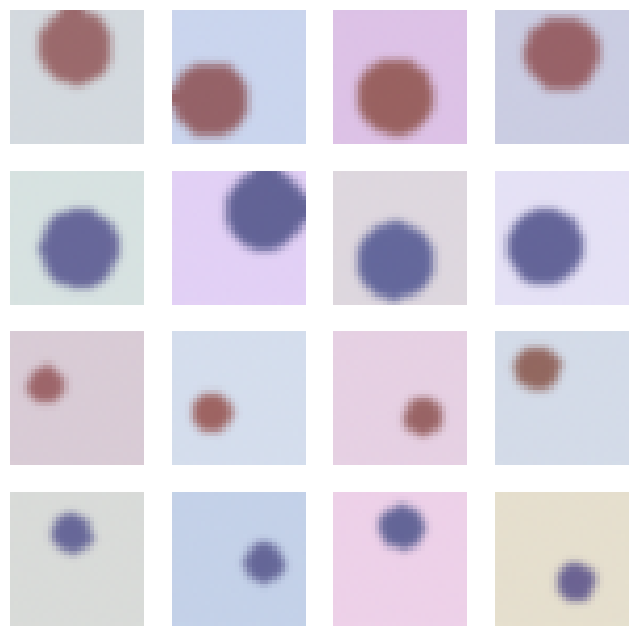

In [32]:
plt.figure(figsize=(8,8))
for row in range(4):
    for col in range(rep):
        plt.subplot(4,rep,row*rep+col+1)
        plt.imshow(ims[row,col].transpose(1,0,2),origin="lower")
        plt.axis("off")

In [45]:
n_classes=8
config["n_samples_train"]=[0]*n_classes
config["n_samples_test"]=[0]*n_classes
config["n_samples_train_gen"]=[0]*n_classes
config["n_samples_test_gen"]=[32]*n_classes
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True,seed=42)

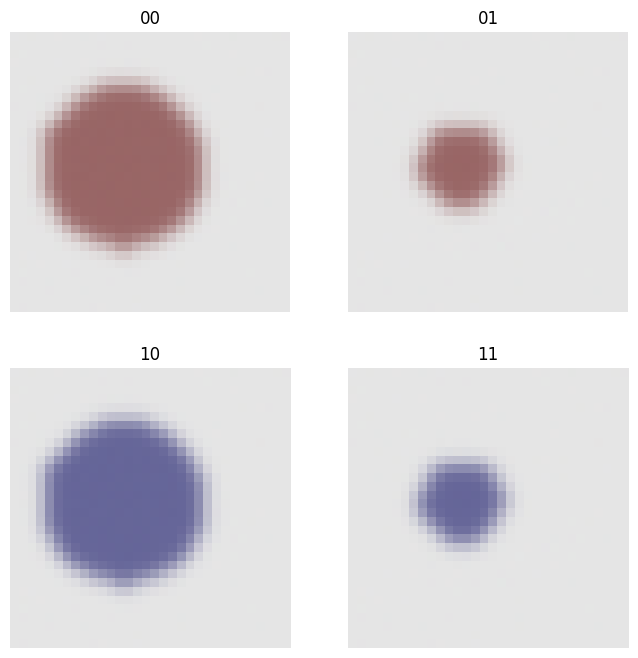

In [47]:
plt.figure(figsize=(8,8))
for l in range(4):
    plt.subplot(2,2,l+1)
    i_rand=16
    plt.imshow(x_te[l_te==l][i_rand].transpose(2,1,0),origin="lower")
    plt.title(["00","01","10","11"][l])
    plt.axis("off")

In [34]:
color_means,size_means  

(array([[0.6, 0.4, 0.4],
        [0.4, 0.4, 0.6]]),
 array([0.6, 0.3]))

In [41]:
# example trying green (doesn't work)

cs=torch.tensor([0.,0., 0., 0., 0.4, 0.6,0.4, 0.6, 0.,0.,0.])[None,:].to(dtype=torch.float32,device=device)

rep=16
with torch.no_grad():
    ims=model.generate(cs.repeat(rep,1)).detach().cpu().numpy()
    ims=np.clip(ims,0,1).transpose(0,2,3,1).reshape(rep,32,32,3)
ims.shape

(16, 32, 32, 3)

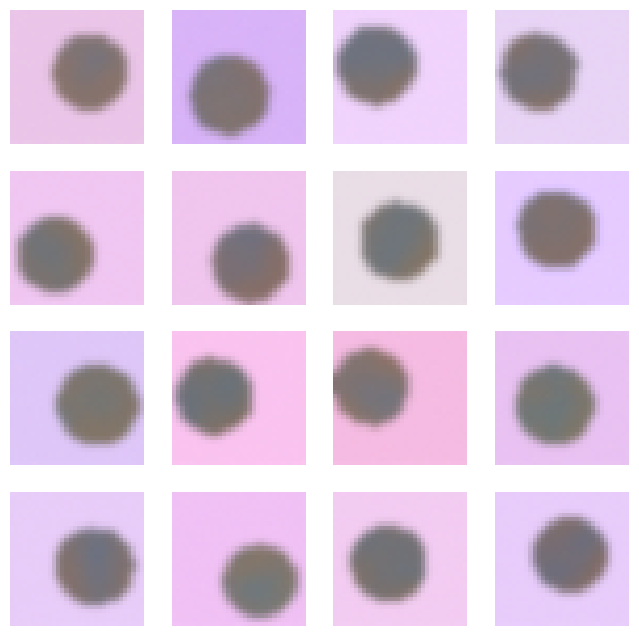

In [42]:
plt.figure(figsize=(8,8))
for row in range(4):
    for col in range(4):
        plt.subplot(4,4,row*4+col+1)
        plt.imshow(ims[4*row+col].transpose(1,0,2),origin="lower")
        plt.axis("off")